In [1]:
import os
import torch
from src import dataset, emote2pitch, training
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


c:\Users\ngrec\AppData\Local\pypoetry\Cache\virtualenvs\aml-emote2pitch-1mtwg_jV-py3.8\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Params

In [2]:
## Params

csv_pth = os.path.join('data', 'pairings', 'FER2constant-q-3-splits-22050Hz.csv')
image_size = 256
num_workers = 0
batch_size = 1 
n_epochs = 2 

device = torch.device("cuda:0" if (torch.cuda.is_available() > 0) else "cpu")
#device ='cpu'

## Dataset

In [3]:
## 
transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ])

emo2pitch_train_set = dataset.EmotePairingDataset(csv_pth, transform=transform, target_transform=transform)

dataloader = torch.utils.data.DataLoader(dataset=emo2pitch_train_set,
                                          batch_size=batch_size,
                                          shuffle=True)

emot shape:  torch.Size([1, 1, 256, 256])
spect shape:  torch.Size([1, 1, 256, 256])


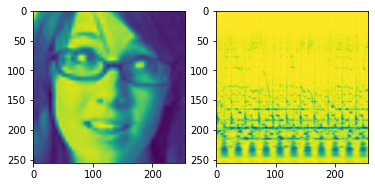

In [4]:
# Plot some training images
real_batch = next(iter(dataloader))
print('emot shape: ', real_batch[0].shape)
print('spect shape: ', real_batch[1].shape)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(real_batch[0][0][0].cpu())
ax2.imshow(real_batch[1][0][0].cpu())

## Model generation

In [5]:
e2p = emote2pitch.Emote2Pitch()

## Testing samples

In [6]:
emots = ['happy', 'angry', 'sad', 'surprise']
root = os.path.join('data','FER', 'test')
test_samples = []

for e in emots:
    emote_pth = os.path.join(root, e)
    sample_files_names = os.listdir(emote_pth)[:2]
    for sample_image in sample_files_names:
        smpl = torch.zeros((1,1,image_size, image_size))
        x = Image.open(os.path.join(emote_pth, sample_image))
        smpl[0] = transform(x)

        test_samples.append((smpl, f'{e}-{sample_image}'))

print(len(test_samples))

8


## Training 

In [7]:
params = {
    'lr':2e-4,
    'betas':(0.5,0.999),
    'batch_size': 1,
    'L1_lambda': 100.0,
    'sample_every':1
}
training.train_emote2pitch(n_epochs, dataloader, device, e2p, params, test_samples=test_samples)

Test sampling : 100%|██████████| 8/8 [00:00<00:00, 67.12 batch/s]
